# **import**
---

In [ ]:
import pandas as pd # reading all required header files
import numpy as np
import random
import operator
import math
import matplotlib.pyplot as plt 
from scipy.stats import multivariate_normal 
from sklearn.datasets import load_iris
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from scipy.ndimage import convolve
from os.path import join
import os
import cv2
from scipy.signal import convolve2d

In [ ]:
base_dir = '/content'
img_path = join(base_dir, 'mdb321.jpg')
assert os.path.exists(img_path)
x = cv2.imread(img_path, 0)

# **FCM (Fuzzy C-means)**
---

> [A fuzzy relative ofthe ISODATA process and its use in detecting compact well-separated clusters](https://www.tandfonline.com/doi/abs/10.1080/01969727308546046)

- **Onjective function**
> ## $J_{m} = \sum_{i=1}^{c}\sum_{k=1}^{N} u_{ik}^{p}||x_k-v_i||^2$

- **calculate center**
> ## $C_i = \frac{\sum_{j=1}^{n} W_{ij}^m x_{j}}{\sum_{j=1}^{n} W_{ij}^m}$

- **partition matrix**
> ## $U_{ij} = \sum_{k=1}^{c}(\frac{||x_j-c_i||}{||x_j-c_k||})^{\frac{-2}{m-1}}$

In [ ]:
def process(data, u0, c, m):
    # Normalizing, then eliminating any potential zero values.
    u0 /= np.ones((c, 1)).dot(u0.sum(axis=0, keepdims=True))
    u0 = np.fmax(u0, np.finfo(np.float64).eps)
    um = u0 ** m # (c, n)
    numerator = um.dot(data)  # (c, n) @ n, ch = (c, ch)
    denominator = um.sum(axis=1, keepdims=True) # c, 1
    cntr = numerator / denominator # (c, ch) / (c, ch) # (c, ch)

    distance = cdist(cntr, data) # c, ch / n, ch
    distance = np.fmax(distance, np.finfo(np.float64).eps) # (c, n)

    jm = (um * distance ** 2).sum()

    m = 0 if m == 1 else (-2. / (m - 1.))
    u = distance ** m # (c, n)
    u /= u.sum(axis=0, keepdims=True)
    return cntr, u, jm, distance


def _fp_coeff(u):
    """
        Fuzzy partition coefficient `fpc` relative to fuzzy c-partitioned
        matrix `u`. Measures 'fuzziness' in partitioned clustering.

        Parameters
        ----------
        u : 2d array (C, N)
            Fuzzy c-partitioned matrix; N = number of data points and C = number
            of clusters.

        Returns
        -------
        fpc : float
            Fuzzy partition coefficient.
    """
    n = u.shape[1]
    return np.trace(u.dot(u.T)) / float(n)

def FCM(data, c, m, error, maxiter):
    n = data.shape[0]
    u = np.random.dirichlet(np.ones(c), n).T
    u = np.fmax(u0, np.finfo(np.float64).eps)

    jm = np.zeros(0)
    for i in range(maxiter-1):
        u2 = u.copy()
        [cntr, u, Jjm, d] = process(data, u2, c, m)
        jm = np.hstack((jm, Jjm))
        if np.linalg.norm(u - u2) < error:
            break
    fpc = _fp_coeff(u) # fuzzy partition coefficient

    return cntr, u, d, jm, fpc

# input = np.random.normal(size=[n, ch])
x = FCM(input, c, m, 0.000001, MAX_ITERS)

## **Result**

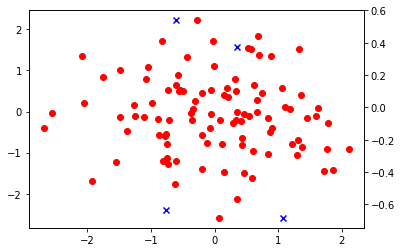

In [ ]:
input = np.random.normal(size=[n, ch])
x = cmeans(input, c, m, 0.0001, MAX_ITERS)

fig, ax1 = plt.subplots()
ax1.scatter(input[:, 0], input[:, 1], c='red', marker='o')
ax2 = ax1.twinx() #한 그래프에 두번째 plot 넣기
ax2.scatter(x[0][:,0], x[0][:,1], c='blue', marker='x')
plt.show()

# FCM_S / BCFCM (Bias-Corrected FCM)
---
> [A Modified Fuzzy C-Means Algorithm for Bias Field Estimation and Segmentation ofMRI Data](https://ieeexplore.ieee.org/document/996338)

    pros
    1. 

    cons
    1. computes the neighbour term in every iteration step, which significantly increases the computational complexity.
    2. the crucial parameter 'a' is only chosen experimentally

- **Objective function**
> ## $\sum_{i=1}^c\sum_{k=1}^Nu^m_{ik}(||x_k-v_i||^2+\frac{\alpha}{N_R}u^m_{ik}||x_k-v_i||^2)$

- **partition matrix**
> # $u_{ji} = \frac{(||x_i-v_j||^2 + \frac{a}{\mathcal{N}_R \sum_{x_r∈\mathcal{N}_i}} ||x_r - v_j||^2)^{1/(m-1)}}{\sum_{k=1}^{c}(||x_i-v_k||^2 + \frac{a}{\mathcal{N}_R \sum_{x_r∈\mathcal{N}_i}} ||x_r - v_j||^2)^{1/(m-1)}}$

- **cluster center**
> # $ v_j = \frac{\sum_{i=1}^N u_{ji}^m (x_i + \frac{a}{N_R} \sum_{r∈\mathcal{N}_i}x_r)}{(1+a) \sum_{i=1}^N u_{ji}^m}$

# FCM_S1 (FCM with Spatial constraints)
---
> [Robust image segmentation using FCM with spatial constraints based on new kernel-induced distance measure](https://ieeexplore.ieee.org/document/1315771)

- **Objective function**
> ## $J_{m} = \sum_{i=1}^{N}\sum_{j=1}^{c} u_{ij}^{m}||x_k-v_i||^2 + α\sum_{r∈\mathcal{N}_i}\sum_{j=1}^{c} u_{ij}^{m} ||\tilde{x}_r-v_i||^2)$

- **partition matrix**
> # $u_{ji} = \frac{(||x_i-v_j||^2 + a ||\tilde{x}_r - v_j||^2)^{1/(m-1)}}{\sum_{k=1}^{c}(||x_i-v_k||^2 + a||\tilde{x}_i - v_k||^2)^{1/(m-1)}}$

- **cluster center**
> # $ v_j = \frac{\sum_{i=1}^N u_{ji}^m (x_i + a \tilde{x_i})}{(1+a) \sum_{i=1}^N u_{ji}^m}$





# EnFCM (Enhanced FCM)
---
> [MR brain image segmentation using an enhanced fuzzy C-means algorithm](https://ieeexplore.ieee.org/document/1279866)

- **AVG**
> ## $ \zeta = |\frac{1}{1+a}(x_i + \frac{a}{N_R}\sum_{j∈N_i}x_j)| = \frac{1}{1+a}(x_k + a\hat{x}_k)$

    - **$N_i$** is stands for the set of neighbors **$x_j$** 
    - filterd image intensity levels are normalized between **[0, 1]**.
    - $N_R$ is cardinality of $N_k$

- **Objective function**
> ## $J_{m} = \sum_{i=1}^{M}\sum_{j=1}^{c} \gamma_i u_{ij}^{m}(\zeta_i - v_j)^2$

    - $M$ denotes the number of gray levels of image $\zeta$
    - <font color='red'>**$\gamma_i$**</font> is the number of pixels having gray level calue equal to **$i$**
> $\sum_{i=1}^M \gamma_i = N$



- **partition matrix**
> # $u_{ji} = [\frac{(\zeta_i - v_j)}{\sum_{k=1}^c(\zeta_i - v_k)}]^{\frac{-2}{m-1}}$

    - **$\zeta_i$** denotes gray level value of $i$th pixel of the image $\zeta$

- **cluster center**
> # $ v_j = \frac{\sum_{i=1}^M \gamma_i u_{ij}^m\zeta_i}{\sum_{i=1}^M \gamma_i u_{ij}^m}$





## **Test**

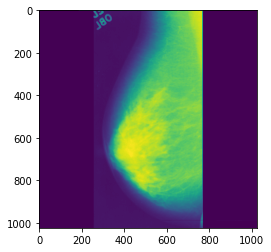

In [ ]:
kernel_size = [3,3]
m = 2
assert np.all(np.remainder(np.array(kernel_size), 2)), f'kernel size must be "odd" number. not "{kernel_size}"'
k = np.ones((kernel_size[0], kernel_size[1]))
k[int(kernel_size[0] / 2), int(kernel_size[1] / 2)] = 0
image = cv2.imread(img_path, 0)

kwargs = {'mode':'same', 'boundary':'fill', 'fillvalue':0}
x = cv2.imread(img_path, 0)
neighbor_sum = convolve2d(x, k, **kwargs)
num_neighbor = convolve2d(np.ones(image.shape), k, **kwargs)
a = x + neighbor_sum / num_neighbor
plt.imshow(a)

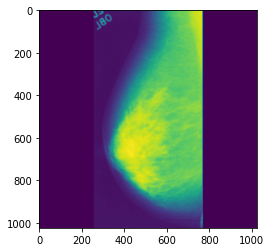

In [ ]:
plt.imshow(neighbor_sum)

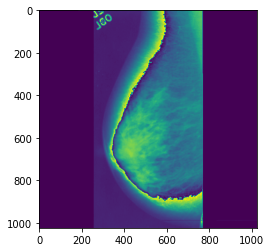

In [ ]:
plt.imshow(a.astype('uint8'))

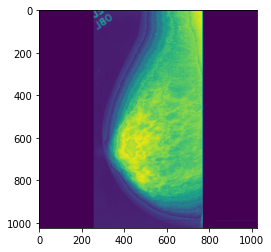

In [ ]:
import scipy
x = cv2.imread(img_path, 0)
kwargs = {'mode':'constant', 'cval':0}
neighbor_sum = scipy.ndimage.convolve(x, k, **kwargs)
num_neighbor = scipy.ndimage.convolve(np.ones(x.shape), k, **kwargs)
a = x + neighbor_sum / num_neighbor
plt.imshow(a)

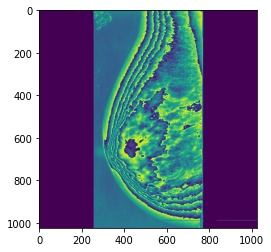

In [ ]:
plt.imshow(neighbor_sum)

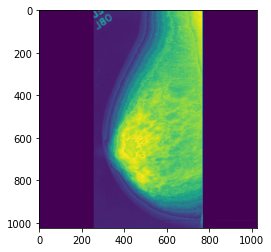

In [ ]:
plt.imshow(a.astype('uint8'))

## **Result**

In [ ]:
def get_zeta(x, k=[5,5], alpha=0.5):
    def mean(x):
        # kwargs = {'mode':'constant', 'cval':0.0}
        kwargs = {'mode':'same', 'boundary':'fill', 'fillvalue':0}
        neighbor_sum = convolve2d(x, kernel, **kwargs)
        cardinality = convolve2d(np.ones(x.shape), kernel, **kwargs)
        return neighbor_sum / cardinality

    assert np.all(np.remainder(np.array(k), 2)), f'kernel size must be "odd" number. not "{kernel_size}"'
    kernel = np.ones((k[0], k[1]))
    kernel[int(k[0]/2), int(k[1]/2)] = 0.
    _x = (x + alpha * mean(x)) / (1 + alpha)
    _x = x.astype(x.dtype)
    return _x
    
def EnFCM(x, c, img_bit=8, k=[5, 5], m=3, alpha=0.5, error=0.0001, maxiter=1000):
    def main():
        x_val = np.arange(n)[:, None]
        # n,1 * n,1 * n,c
        numerator = np.sum(hist * x_val * pow(u, m), axis=0)
        denominator = np.sum(hist * pow(u, m), axis=0) # n,1 / n,c
        center = numerator / denominator

        center, gray_val = np.meshgrid(center, np.arange(n))
        numerator = abs(gray_val - center) ** (-2. / (m - 1))
        denominator = numerator.sum(axis=1, keepdims=True)
        # denominator = np.fmax(denominator, np.finfo(np.float64).eps)
        return numerator / denominator

    n = (1<<img_bit)
    u = np.random.dirichlet(np.ones(c), n) # n, c
    u = np.fmax(u, np.finfo(np.float64).eps)
    # jm = np.zeros(0)
    z = get_zeta(x, k, alpha)
    hist = cv2.calcHist([z], [0], None, [n], [0, n])
    for i in range(maxiter-1):
        u0 = u.copy()
        u = main()
        if np.linalg.norm(u - u0) < error:
            break
    result = np.argmax(u, axis=1)
    for i in range(len(result)):
        x[x==i] = result[i]

    return x.reshape(x.shape).astype('int')

In [ ]:
x = cv2.imread(img_path, 0)
tmp = EnFCM(x, 4)
plt.imshow(tmp)


# MFCM (Modified FCM)
---
> [A Modified Fuzzy C-Means Algorithm for Breast Tissue Density Segmentation in Mammograms](https://ieeexplore.ieee.org/document/5687751)


- **Local window filter**
> ## $C_{kr} = \{^{C_{kr_s} * C_{kr_g},\ (if\ r∈N_r)} _{0}$
\
> ## $C_{kr\_s} = exp(-d_{kr_s})$
>> $d_{kr\_s}$ denotes Euclidean distance between pixels $k$ and $r$.
\
> ## $C_{kr\_g} = exp(\frac{-||x_l-x_r||^2}{\lambda_g\ *\ \sigma^2_{kr\_g}})$

- **deviation**
> ## $ \sigma_k = (\sum_{r∈N_k} (x_r-\hat{x}_k)^2)/n_k)^\frac{1}{2}$
\
$\hat{x}$ denotes median intensity value of $x$
\
if the difference between $x_r$ and $\hat{x}_k$ is larger than $\sigma_k$, pixel $r$ is evaluated unreliable

- **cluster center**
> # $ v_j = \frac{\sum_{r∈N_k} C_{kr}\ *\ x_r}{\sum_{r∈N_k} C_{kr}}$

- **partition matrix**
> # $u_{ji} = \frac{(\zeta_i - v_j)^{2/(m-1)}}{\sum_{k=1}^c(\zeta_i - v_k)^{2/(m-1)}}$






In [ ]:
import numpy as np

C = 2
shape = [1,3,3, C]
x = np.reshape(np.arange(np.prod(shape), dtype='int8'), shape)#.transpose(2,3,1,0)

def extract_patches(x, sizes=(1,3,3,1), strides=(1,1,1,1), rates=(1,1,1,1), padding=0):
    assert tuple(sizes)[slice(None, None, 3)] == (1,1) and len(sizes) == 4
    assert tuple(strides)[slice(None, None, 3)] == (1,1) and len(strides) == 4
    assert tuple(rates)[slice(None, None, 3)] == (1,1) and len(rates) == 4

    shape, sizes, strides = np.array(x.shape), np.array(sizes), np.array(strides)
    if padding != 0:
        # p = n(s-1)+k-s
        pad = shape*(strides-1) + sizes - strides
        pad = np.stack([pad, pad], 1)#.transpose()
        pad[:, 0], pad[:, 1] = np.floor(pad[:, 0]/2), np.ceil(pad[:, 1]/2)
        pad.astype('int8')
        x = np.pad(x, pad)
        padding = np.sum(pad, 1)
    sizes = np.array(sizes, dtype=shape.dtype)
    slices = tuple(slice(None, None, s) for s in strides)
    idx_strides = x[slices].strides
    idx_shape = ((shape - sizes + padding) // strides)+1
    assert np.all(idx_shape), f'invalide shape input: {idx_shape}'
    new_shape = list(idx_shape) + list(sizes)
    strides = idx_strides + x.strides
    # new_shape = list(idx_shape)[:-1] + list(sizes)[1:-1] + [list(idx_shape)[-1]]
    # strides = list(idx_strides)[0:-1] + list(x.strides)[1:-1] + [idx_strides[-1]]
    """
    B, C 를 같이 계산할 경우 shape 과 strides 에도 따로 계산을 해야 한다.
    transpose 포함해야 함, 따라서 일반 계산 후 한꺼번에 transpose 를 하는 것이 더 합리적.
    """
    output = np.lib.stride_tricks.as_strided(x, shape=new_shape, strides=strides)
    output = output.transpose([0,4,1,2,5,6,3,7]) # non-direct method
    output = np.reshape(output, [idx_shape[0], *idx_shape[1:-1], -1])
    return output

# print(np.squeeze(x))
# x = extract_patches(x, (1, 2, 2, 1), [1, 1, 1, 1], padding=1)
# x = np.reshape(x, [-1, *x.shape[1:-1], x.shape[3]//C, C]) # B I 
# print(np.squeeze(x), x.shape)

In [ ]:
def extract_patches(x, sizes, strides, rates=(1,1), padding=0):
    shape, sizes, strides = np.array(x.shape), np.array(sizes), np.array(strides)
    if padding != 0:
        # p = n(s-1)+k-s
        pad = shape*(strides-1) + sizes - strides
        pad = np.stack([pad, pad], 1)#.transpose()
        pad[:, 0], pad[:, 1] = np.floor(pad[:, 0]/2), np.ceil(pad[:, 1]/2)
        pad.astype('int8')
        x = np.pad(x, pad)
        padding = np.sum(pad, 1)
    sizes = np.array(sizes, dtype=shape.dtype)
    slices = tuple(slice(None, None, s) for s in strides)
    idx_strides = x[slices].strides
    idx_shape = ((shape - sizes + padding) // strides)+1
    assert np.all(idx_shape), f'invalide shape input: {idx_shape}'
    new_shape = list(idx_shape) + list(sizes)
    strides = idx_strides + x.strides
    output = np.lib.stride_tricks.as_strided(x, shape=new_shape, strides=strides)
    output = np.reshape(output, [*idx_shape, -1])
    return output

def window_distance(k):
    import scipy
    window = np.ones(k)
    L = []
    [L.append(int(i/2)) for i in k]
    window[tuple(L)] = 0
    return scipy.ndimage.distance_transform_edt(window)

def masking(x, axis=-1):
    norm = x-np.median(x, axis=axis, keepdims=True)
    stddev = np.std(norm, axis=axis, keepdims=True)
    return (norm<=stddev).astype(int)

def center_idx(kernel):
    center_strides = [k//2 * kernel[i-1] if i != 0 else k//2 for i, k in enumerate(kernel)]
    return np.sum(center_strides)

def get_zeta(x, k=[5,5], Lg=0.5):
    _, H,W,C = x.shape
    distance = window_distance(k)
    x = extract_patches(x, k=k, padidng=1)
    mask = masking(x)
    center = np.expand_dims(np.take(x, center_idx(k)), -1)
    norm_gray = x - center
    gray_stddev = np.sqrt(np.sum((norm_gray * mask) ** 2)) / np.count_nonzero(reliable_mat)

    coeff_g = np.exp(-norm_gray**2 * mask)/(Lg*gray_stddev)
    coeff_d = np.exp(-distance*mask)
    coeff = coeff_g*coeff_d
    x = (coeff * x) / coeff
    x = np.reshape(x, [-1, H, W, x.shape[3]//C, C])
    x = np.transpose(x, [0, 1, 2, 4, 3])
    x = np.sum(x, -1)
    return x

def MFCM(x, c, img_bit=8, k=[5, 5], m=2, alpha=0.5, error=0.001, maxiter=1000):
    def main():
        x_val = np.arange(n)[:, None]
        # n,1 * n,1 * n,c
        numerator = np.sum(hist * x_val * pow(u, m), axis=0)
        denominator = np.sum(hist * pow(u, m), axis=0) # n,1 / n,c
        center = numerator / denominator

        c_mesh, idx_mesh = np.meshgrid(center, np.arange(n))
        numerator = abs(idx_mesh - c_mesh) ** (-2. / (m - 1))
        denominator = numerator.sum(axis=1, keepdims=True)
        denominator = np.fmax(denominator, np.finfo(np.float64).eps)
        return numerator / denominator#[:,None]

    n = (1<<img_bit)
    u = np.random.dirichlet(np.ones(c), n) # n, c
    u = np.fmax(u, np.finfo(np.float64).eps)
    # jm = np.zeros(0)
    z = get_zeta(x, k)
    hist = cv2.calcHist([z], [0], None, [n], [0, n])
    for i in range(maxiter-1):
        u0 = u.copy()
        u = main()
        break
        if np.linalg.norm(u - u0) < error:
            break
    result = np.argmax(u, axis=1)
    for i in range(len(result)):
        x[x==i] = result[i]

    return x.reshape(x.shape).astype('int')

# FGFCM (Fast Generalized FCM)
---
> [Fast and robust fuzzy c-means clustering algorithms incorporating local information for image segmenta-
tion](https://www.sciencedirect.com/science/article/abs/pii/S0031320306003451?via%3Dihub)

eliminate the aspects associated with **$a$**\
factor $S_{ij} = S_{s\_ij} . S_{g\_ij}$ was defined as a local similarity measure to replace the parameter **$a$**

- **Factor $S$ incorporating both the local spatial relationship ($S_s$) and the local gray level relationship ($S_g$) to replace param $\alpha$**
># $S_{ij} = \{^{(i≠j),\ S_{s\_ij}\ *\ S_{g\_ij}}_{(i=j), 0}\}$

- **local spatial relationship**
># $S_{s\_ij} = exp(\frac{-max(|p_i-p_j|, |q_i-q_j|)}{λ_s})$

- **local gray level relationship**
># $S_{g\_ij} = exp(\frac{-||x_i-x_j||^2}{λ_g * \sigma^2_{g\_i}})$

- **local density surrounding the central pixel**
># $σ_i = (\frac{\sum_{j∈N_i}||x_i-x_j||^2}{N_R})^\frac{1}{2}$

- **new generated image**
># $\zeta_i = \frac{\sum_{j∈N_i} S_{ij}x_j}{\sum_{j∈N_i} S_{ij}}$





In [ ]:
def window_distance(k):
    import scipy
    window = np.ones(k)
    L = []
    [L.append(int(i/2)) for i in k]
    window[tuple(L)] = 0
    return scipy.ndimage.distance_transform_edt(window)

def masking(x, axis=-1):
    norm = x-np.median(x, axis=axis, keepdims=True)
    stddev = np.std(norm, axis=axis, keepdims=True)
    return (norm<=stddev).astype(int)

def center_idx(kernel):
    center_strides = [k//2 * kernel[i-1] if i != 0 else k//2 for i, k in enumerate(kernel)]
    return np.sum(center_strides)

def get_zeta(x, k=[5,5], Lg=0.5):
    C = x.shape[-1]
    distance = window_distance(k)
    x = extract_patches(x, k=k, padidng=1)
    mask = masking(x)
    center = np.expand_dims(x[..., center_idx(k)], -1)
    norm_gray = x - center
    gray_stddev = np.sqrt(np.sum((norm_gray * mask) ** 2)) / np.count_nonzero(reliable_mat)

    coeff_g = np.exp(-norm_gray**2 * mask)/(Lg*gray_stddev)
    coeff_d = np.exp(-np.maximum())
    coeff = coeff_g*coeff_d
    x = (coeff * x) / coeff
    x = np.reshape(x, [-1, *x.shape[1:-1], x.shape[3]//C, C])
    x = np.transpose(x, [0, 1, 2, 4, 3])
    x = np.sum(x, -1)
    return x

def MFCM(x, c, img_bit=8, k=[5, 5], m=2, alpha=0.5, error=0.001, maxiter=1000):
    def main():
        x_val = np.arange(n)[:, None]
        # n,1 * n,1 * n,c
        numerator = np.sum(hist * x_val * pow(u, m), axis=0)
        denominator = np.sum(hist * pow(u, m), axis=0) # n,1 / n,c
        center = numerator / denominator

        c_mesh, idx_mesh = np.meshgrid(center, np.arange(n))
        numerator = abs(idx_mesh - c_mesh) ** (-2. / (m - 1))
        denominator = numerator.sum(axis=1, keepdims=True)
        denominator = np.fmax(denominator, np.finfo(np.float64).eps)
        return numerator / denominator#[:,None]

    n = (1<<img_bit)
    u = np.random.dirichlet(np.ones(c), n) # n, c
    u = np.fmax(u, np.finfo(np.float64).eps)
    # jm = np.zeros(0)
    z = get_zeta(x, k)
    hist = cv2.calcHist([z], [0], None, [n], [0, n])
    for i in range(maxiter-1):
        u0 = u.copy()
        u = main()
        break
        if np.linalg.norm(u - u0) < error:
            break
    result = np.argmax(u, axis=1)
    for i in range(len(result)):
        x[x==i] = result[i]

    return x.reshape(x.shape).astype('int')

# **FLICM (Fuzzy Local Information C-Means)**
---
> [A Robust Fuzzy Local Information C-Means Clustering Algorithm](https://ieeexplore.ieee.org/document/5393030)

- **Fuzzy factor**
> ## $G_{ki} = \sum_{jN_i\\i≠j}\frac{1}{d_{ij}+1}(1-u_kj)^m||x_j-v_k||^2$

    - ***i*** th pixel is the center of the local window
    - ***k*** is the reference cluster
    - The ***j*** th pixel belongs in the set of the neighbors falling into a window around the ***i***th pixel ($N_i$)
    - **$d_{ij}$** is the spatial Eucliean distance

- **Objective function**
> ## $J_{m} = \sum_{i=1}^{N}\sum_{k=1}^{c} [u_{ij}^{m}||x_i - v_k||^2 + G_{ki}]$

- **partition matrix**
> # $u_{ki} = \sum_{j=1}^c(\frac{||x_i-v_k||^2+G_{ki}}{||x_i-v_j||^2+G_{ji}})^{-1/(m-1)}$

- **cluster center**
> # $ v_k = \frac{\sum_{i=1}^N u_{ki}^m x_i}{\sum_{i=1}^N u_{ki}^m}$





# **BCEFCM (Bias Correction Embedded Fuzzy C-Means)**
---
> [Image segmentation using CUDA accelerated non-local means denoising and bias correction embedded fuzzy c-means (BCEFCM)](https://www.sciencedirect.com/science/article/abs/pii/S016516841500434X)




# **RC_LCI (Robust Clustering with Local Contextual Information)**
---
> [A Robust Brain MRI Segmentation and Bias Field Correction Method Integrating Local Contextual
Information into a Clustering Model](https://www.mdpi.com/2076-3417/9/7/1332)

## **Anistopic Weighting Scheme (Denoising)**
- **The gray mean square error**
> ## $\sigma_{xy} = [\frac{\sum_{y'∈N_x}y\ (I_{y'}-I_y)^2}{n_x - 1}]^{\frac{1}{2}}$

- **The gray mean square error**
> ## $\gamma_{xy} = exp[-σ+\frac{\sum_{y∈N_x}σ_{xy}}{n_x}]$

- **Weight normalization**
> ## $η_{xy} = \frac{γ_{xy}}{\sum_{y∈N_x}γ_{xy}}$

- **Image updated according to simiar pixels in the neighborhood and corresponding weights**
> ## $I_w(x) = \sum_{y∈N_x}I_y *γ_{xy}$

w 3.4102526090422103 (1, 478, 356, 9, 1)
norm 0.07408501971518595 (1, 478, 356, 9, 1)
1.0 (1, 478, 356, 1)
(478, 356) (478, 356)
128.55010342720135 128.55010342720135


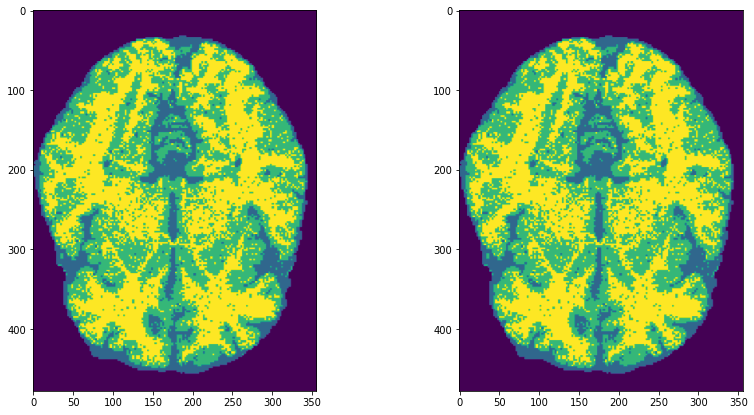

In [46]:
def denoising(x, k=[3,3]):
    input = x
    C = x.shape[-1]
    x = extract_patches(x, padding=1)
    x = np.reshape(x, [-1, *x.shape[1:-1], x.shape[3]//C, C]) # B I k C
    center = np.expand_dims(x[..., center_idx(k), :], -2)

    mse = (x-center)**2 / (np.prod(k)-1)
    mse = mse**0.5
    # mse = np.sum(mse, -2)**0.5 # B, I, C
    """ How to take into account number of 0 padding in border of the image """
    # axis = tuple([i for i in range(1, len(mse.shape)-1)])
    axis = -2
    w = np.exp(-mse + np.mean(mse, axis, keepdims=True))
    print('w', np.std(w), w.shape)
    norm = w / np.sum(w, axis, keepdims=True)
    # norm = np.sum(norm, -2)
    print('norm', np.std(norm), norm.shape)
    norm = np.sum(norm, -2)
    print(np.mean(norm), norm.shape)
    return input * norm

base_dir = '/content'
img_path = join(base_dir, 'noisy image.png')
assert os.path.exists(img_path)
x = cv2.imread(img_path, 0)
y = denoising(x[None, :, :, None])
print(x.shape, np.squeeze(y).shape)
cols, rows = 1, 2
figure, axs  = plt.subplots(cols, rows, figsize=(rows*7,cols*7))
axs[0].imshow(x)
axs[1].imshow(np.squeeze(y))
print(np.mean(x), np.mean(y))

(1, 478, 356, 9, 1)
(478, 356) (478, 356)


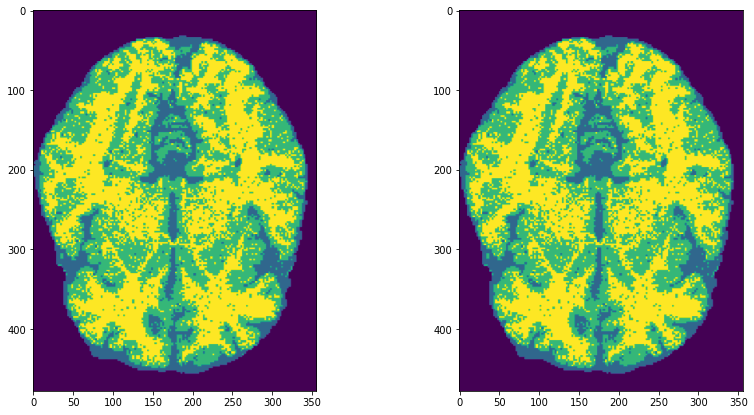

In [ ]:
base_dir = '/content'
img_path = join(base_dir, 'noisy image.png')
assert os.path.exists(img_path)
x = cv2.imread(img_path, 0)
y = denoising(x[None, :, :, None])
print(x.shape, np.squeeze(y).shape)
cols, rows = 1, 2
figure, axs  = plt.subplots(cols, rows, figsize=(rows*7,cols*7))
axs[0].imshow(x)
axs[1].imshow(np.squeeze(y))

(478, 356) (478, 356)


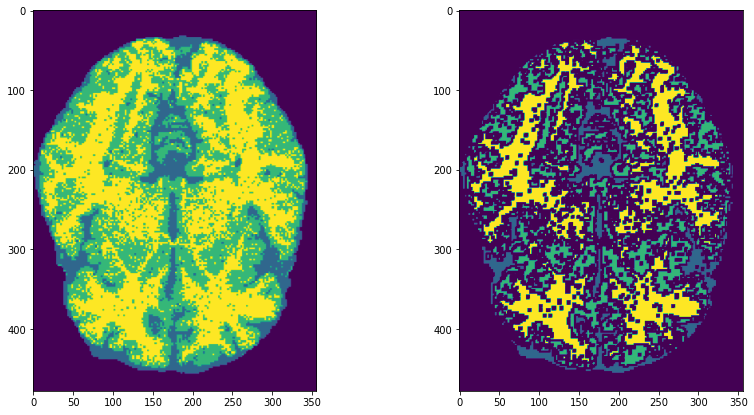

In [ ]:
base_dir = '/content'
img_path = join(base_dir, 'noisy image.png')
assert os.path.exists(img_path)
x = cv2.imread(img_path, 0)
y = denoising(x[None, :, :, None])
print(x.shape, np.squeeze(y).shape)
cols, rows = 1, 2
figure, axs  = plt.subplots(cols, rows, figsize=(rows*7,cols*7))
axs[0].imshow(x)
axs[1].imshow(np.squeeze(y))

## **Bias Field Framework**

- **Observed MRI I**
> ## $I(x) = b(x) * J(x) + n(x)$
    - $b(x)$ represents the bias field
    - $J(x)$ is the real image
    - $n(x)$ is the zero-mean additive Gaussian noise
    - linear combination of multiple-order **legendre polynomial functions** was used as the basis function

    - $b(x)$
    >  $b(x) = \sum^M_{i=1}w_i g_i$
        - $g_1, ... , g_M$ are the basis functions.
        - $w_1, ... , w_M$ are the optimal coefficients.

    - $J(x)$
    > $J(x) = \sum_{i=1}^N c_i u_i(x)$
        - $u_i$ is a binary function


## **Energy Formulation**

- **Energy function**
> ## $F(b,J) = \int_Ω |I_w(x) - b(x)J(x)|^2dx$
    - $I_w(x)$ is the denoising image after using the anisotropic weighing scheme


- **Exchanging the order of the integral and summations**
> ## $F(w,c,u) = \int_Ω λ_i\sum^N_{i=1}|I_w(x)-w^TG(x)c_i|^2u_i(x)dx$
    - $λ_i$ is the weighting coefficient for the $i$-th cluster center
    - $u_i$ is a binary membership function 




In [ ]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.legendre.html
scipy.special.legendre()

## **Energy Minimization**

- **Weight**
> ## $w = [∫_ΩG(x)G^T(x)(λ_i\sum^N_{i=1}c^2_iu_i(x))dx]^{-1} ∫_ΩG(x)I_w(x)(λ_i\sum^N_{i=1}c_iu_i(x))dx$

- **Center**
> ## $c_i = \frac{∫_ΩI_w(x)b(x)u_i(x)dx}{∫_Ωb^2(x)u_i(x)dx}, i=1, ... , N$

- **Membership**
> ## $u_i(x) = \{^{1,\ i=argmin(α_i[I_w(x)])}_{0,\ i≠argmin(α_i[I_w(x)])}\}$
    - $α_i(x) = |I_w(x) - w^TG(x)c_i|^2$

